In [56]:
# Configuration Settings
INPUT_FILE = "../../outputs/Mexico_wosis_merged.csv"
YEAR_RANGE = [1970, 2005]
TARGET_COLUMN = 'orgc_value'
FEATURE_COLUMNS = ['upper_depth', 'lower_depth', 'clay_value', 'phaq_value', 'sand_value', 'silt_value']
TRAINING_YEAR_RANGE = [1970, 2004] # exclusive of 2005
PREDICTION_YEAR_RANGE = [2004, 2005]  # both inclusive
SEQUENCE_LENGTH = 12  # Time steps in the sequence
BATCH_SIZE = 32
EPOCHS = 150
PATIENCE = 20

#---------- DO NOT EDIT BELOW THIS LINE ----------

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dropout, Dense # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # type: ignore
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

In [58]:
def load_and_preprocess_data():
    """Loads data from the CSV file and preprocesses it."""
    df = pd.read_csv(INPUT_FILE)
    df = df[FEATURE_COLUMNS + [TARGET_COLUMN] + ['date']].copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date')
    df.set_index('date', inplace=True)
    
    # Filter data based on the provided year range
    df = df[(df.index.year >= YEAR_RANGE[0]) & (df.index.year <= YEAR_RANGE[1])]
    
    # Handle missing values by filling with column mean
    df[FEATURE_COLUMNS] = df[FEATURE_COLUMNS].fillna(df[FEATURE_COLUMNS].mean())
    df[TARGET_COLUMN] = df[TARGET_COLUMN].fillna(df[TARGET_COLUMN].mean())
    
    return df

In [59]:
def plot_time_series(df, title):
    """Plots the time series of the target variable."""
    plt.plot(df.index, df[TARGET_COLUMN], label=TARGET_COLUMN)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.show()

In [60]:
def create_sequences(data, target, n_length):
    """Generates sequences for training the LSTM model."""
    X, y = [], []
    for i in range(len(data) - n_length):
        X.append(data[i:i + n_length])
        y.append(target[i + n_length])
    return np.array(X), np.array(y)


In [61]:

def scale_data(df_train, df_test):
    """Scales feature columns and target column using MinMaxScaler."""
    scaler = MinMaxScaler()
    
    # Scale feature columns
    df_train[FEATURE_COLUMNS] = scaler.fit_transform(df_train[FEATURE_COLUMNS])
    df_test[FEATURE_COLUMNS] = scaler.transform(df_test[FEATURE_COLUMNS])
    
    # Scale target column
    df_train[TARGET_COLUMN] = scaler.fit_transform(df_train[[TARGET_COLUMN]])
    df_test[TARGET_COLUMN] = scaler.transform(df_test[[TARGET_COLUMN]])
    
    return scaler, df_train, df_test


In [62]:

def build_model(input_shape, lstm_units=64, dropout_rate=0.2):
    """Builds and compiles the LSTM model."""
    model = Sequential()
    model.add(LSTM(lstm_units, activation='relu', input_shape=input_shape, 
                   return_sequences=True, recurrent_dropout=0.1))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units // 2, activation='relu', recurrent_dropout=0.1))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
    return model


In [63]:

def train_model(model, X_train, y_train):
    """Trains the LSTM model with early stopping and model checkpoint."""
    early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
    
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, 
                        validation_split=0.2, callbacks=[early_stopping, model_checkpoint], verbose=1)
    return model, history

In [64]:
def evaluate_model(model, X_test, y_test, scaler):
    """Evaluates the model and generates performance metrics."""
    # Make predictions
    predictions = model.predict(X_test)
    
    # Inverse transform predictions and actual values
    predicted_values = scaler.inverse_transform(predictions)
    actual_values = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Model Evaluation Metrics
    mse = mean_squared_error(actual_values, predicted_values)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_values, predicted_values)
    r2 = r2_score(actual_values, predicted_values)
    
    print("\nModel Performance Metrics:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R2): {r2:.4f}")
    
    return predicted_values, actual_values

In [65]:
def plot_predictions_vs_actual(predicted_values, actual_values, df_test):
    """Plots the actual vs predicted values."""
    plt.figure(figsize=(12, 6))
    plt.plot(df_test.index[SEQUENCE_LENGTH:], actual_values, label="Actual Values", color="blue", alpha=0.7)
    plt.plot(df_test.index[SEQUENCE_LENGTH:], predicted_values, label="Predictions", color="red", linestyle="--", alpha=0.7)
    plt.xlabel("Date")
    plt.ylabel(f"{TARGET_COLUMN} (Original Scale)")
    plt.title(f"Predictions vs Actual Values for {TARGET_COLUMN}")
    plt.legend()
    plt.grid(True)
    plt.show()

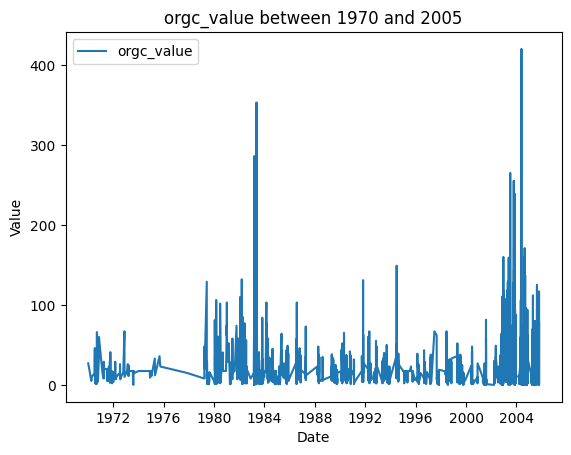

,upper_depth,lower_depth,clay_value,phaq_value,sand_value,silt_value,orgc_value
date,,,,,,,
1970-01-08,0,25,20.0,6.5,50.0,30.0,27.0
1970-04-10,0,25,12.0,8.1,64.0,24.0,5.0
1970-04-22,0,20,18.0,8.8,52.0,30.0,10.0
1970-07-15,0,21,19.0,7.6,55.0,26.0,15.0
1970-07-15,0,15,21.0,8.3,47.0,32.0,30.0
...,...,...,...,...,...,...,...
2003-12-11,0,18,52.0,8.9,18.0,30.0,13.0
2003-12-11,0,30,20.0,4.6,64.0,16.0,10.0
2003-12-12,0,22,24.0,5.4,50.0,26.0,48.0


,upper_depth,lower_depth,clay_value,phaq_value,sand_value,silt_value,orgc_value
date,,,,,,,
2004-03-23,0,26,16.0,5.3,60.0,24.0,10.0
2004-03-24,0,24,8.0,5.6,80.0,12.0,3.0
2004-03-24,0,20,6.0,6.5,90.0,4.0,1.0
2004-03-25,0,7,14.0,5.4,60.0,26.0,10.0
2004-03-26,0,21,16.0,4.9,72.0,12.0,13.0
...,...,...,...,...,...,...,...
2004-11-27,0,24,32.0,5.6,52.0,16.0,41.0
2004-11-27,0,23,16.0,6.1,78.0,6.0,11.0
2004-11-28,0,12,61.0,6.2,24.0,15.0,50.0


Epoch 1/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0038 - mae: 0.0393 - mse: 0.0038 - val_loss: 0.0074 - val_mae: 0.0483 - val_mse: 0.0074
Epoch 2/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0039 - mae: 0.0377 - mse: 0.0039 - val_loss: 0.0078 - val_mae: 0.0442 - val_mse: 0.0078
Epoch 3/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0033 - mae: 0.0356 - mse: 0.0033 - val_loss: 0.0077 - val_mae: 0.0446 - val_mse: 0.0077
Epoch 4/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0035 - mae: 0.0354 - mse: 0.0035 - val_loss: 0.0075 - val_mae: 0.0468 - val_mse: 0.0075
Epoch 5/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0029 - mae: 0.0348 - mse: 0.0029 - val_loss: 0.0076 - val_mae: 0.0461 - val_mse: 0.0076
Epoch 6/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0036 - mae: 0.0365 - mse: 0.0036 - val_loss: 0.0076 - val_mae: 0.0457 - val_mse: 0.0076
Epoch 7/150
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0031 - mae: 0.0342 - mse: 0.0031 - val_loss: 

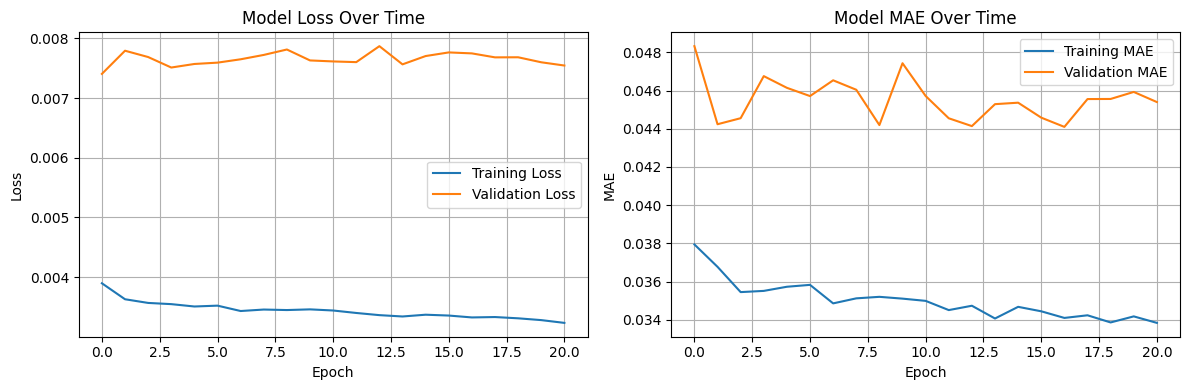

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

Model Performance Metrics:
Mean Squared Error (MSE): 580.3477
Root Mean Squared Error (RMSE): 24.0904
Mean Absolute Error (MAE): 14.4941
R-squared (R2): -0.0129


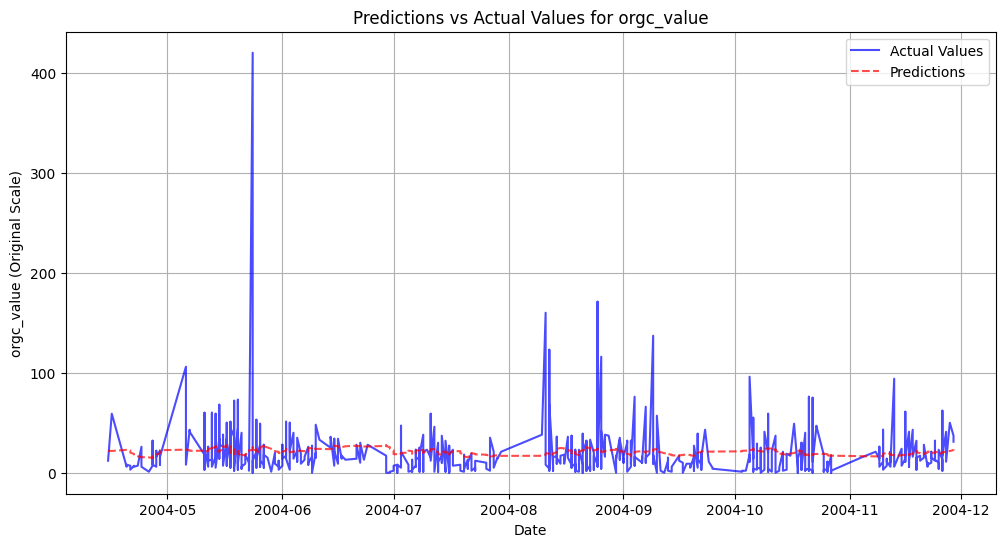

In [66]:
# Load and preprocess data
df = load_and_preprocess_data()

# Visualize target variable
plot_time_series(df, f'{TARGET_COLUMN} between {YEAR_RANGE[0]} and {YEAR_RANGE[1]}')

# Create training and testing datasets
df_train = df[(df.index.year >= TRAINING_YEAR_RANGE[0]) & (df.index.year < TRAINING_YEAR_RANGE[1])].copy()
df_test = df[(df.index.year >= PREDICTION_YEAR_RANGE[0]) & (df.index.year < PREDICTION_YEAR_RANGE[1])].copy()

display(df_train)
display(df_test)

# Scale the data
scaler, df_train, df_test = scale_data(df_train, df_test)

# Generate sequences for training and testing
X_train, y_train = create_sequences(df_train[FEATURE_COLUMNS].values, df_train[TARGET_COLUMN].values, SEQUENCE_LENGTH)
X_test, y_test = create_sequences(df_test[FEATURE_COLUMNS].values, df_test[TARGET_COLUMN].values, SEQUENCE_LENGTH)

# Reshape data for LSTM [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], len(FEATURE_COLUMNS))
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], len(FEATURE_COLUMNS))

# Build and compile the model
model = build_model(input_shape=(X_train.shape[1], X_train.shape[2]))

# Train the model
model, history = train_model(model, X_train, y_train)

# Plot training history (Loss and MAE)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE Over Time')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate the model and make predictions
predicted_values, actual_values = evaluate_model(model, X_test, y_test, scaler)

# Plot actual vs predicted values
plot_predictions_vs_actual(predicted_values, actual_values, df_test)